In [1]:
import numpy as np
import torch

from torch import nn
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer
import mclnn

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
conf.columns, conf.column_encoder = utils.read_columns()

In [ ]:
train_x, train_y, _ = utils.read_dataset_kirill_split("./data/train_curated.csv", "./splits/split/train", conf, None)
test_x, test_y, _ = utils.read_dataset_kirill_split("./data/train_curated.csv", "./splits/split/val", conf, None)

100%|██████████| 506/506 [00:27<00:00, 18.17it/s]


In [ ]:
train_dataset = trainer.SoundDataset(train_x, train_y)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [ ]:
model = nn.Sequential(
    mclnn.CLNNModule(128, 256, 4, dilation=1, mask_params={"bandwidth":64, "overlap":32}),
    nn.LeakyReLU(),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1, mask_params={"bandwidth":64, "overlap":32}),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.BatchNorm(256),
    mclnn.CLNNModule(256, 256, 4, dilation=1),
    nn.LeakyReLU(),
    mclnn.TemporalPool(2),
    mclnn.CLNNModule(256, 256, 4),
    nn.LeakyReLU(),
    mclnn.TemporalPool(4),
    mclnn.BatchNorm(256),
    mclnn.Flatten(),
    nn.Linear(256*8, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, len(conf.columns))
)

In [ ]:
device = torch.device("cuda")

model = model.to(device)

In [ ]:
def optimizer_factory(params):
    result = torch.optim.Adam(params, lr=1e-3)
    return result
    
def scheduler_factory(optimizer):
    result = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
    return result

In [ ]:
tr = trainer.Trainer(model, optimizer_factory, scheduler_factory, device, {"path":"./experiments/paper_final/"})

Saving the weights and metrics to  ./experiments/paper_final/2019-06-17.19.07.52


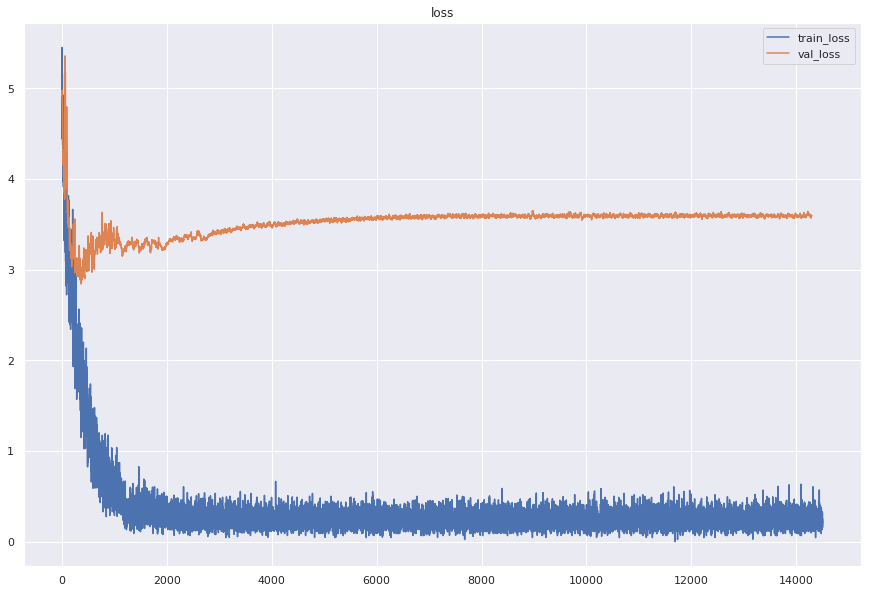

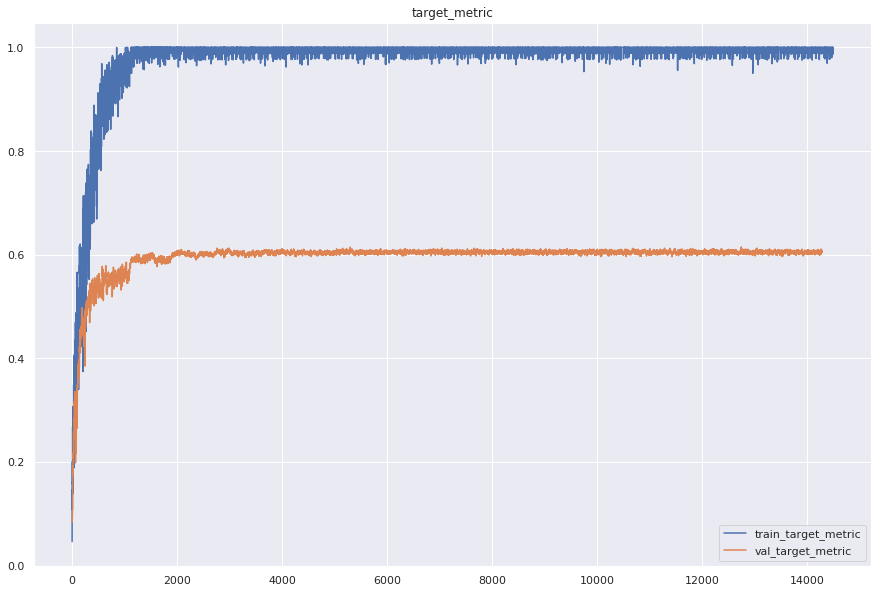

In [16]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":1, "grad_clip_norm":10.0, "validate_every":25},
)

In [13]:
tr.save_path

'./experiments/paper_final/2019-06-17.19.07.52'

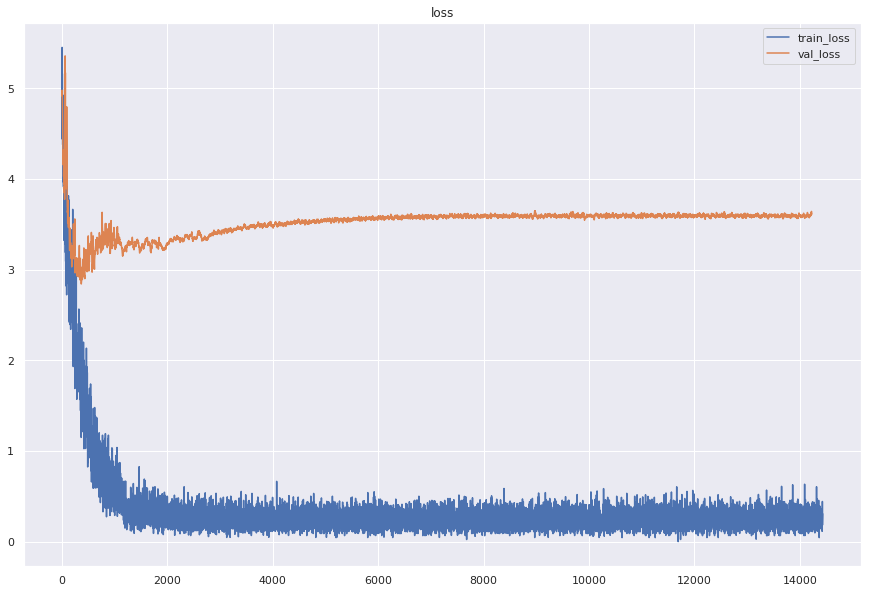

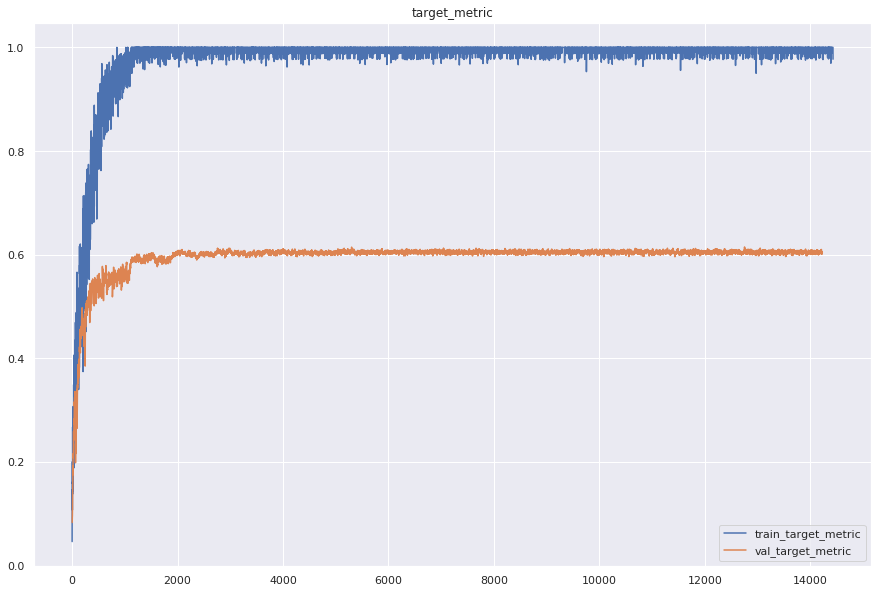

In [14]:
tr.plot(tr.train_metrics, tr.val_metrics)